# Inference

In [1]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from predictor import NUCLEIdemo
from predictor_coco import COCODemo
from PIL import Image
import numpy as np
from maskrcnn_benchmark.config import cfg
import os
import torch
from maskrcnn_benchmark.config.paths_catalog import DatasetCatalog
from maskrcnn_benchmark.utils.imports import import_file

In [2]:
# increasing the size of figures
#pylab.rcParams['figure.figsize'] = 20, 12

CONFIGS = '../configs/'
#CONFIGS = '/home/maxsen/git/ms2/code/configs/'
#CONFIGS = '/home/max/github/ms2/code/configs/'

In [3]:
# load config file

config_file = CONFIGS + 'nuclei_1gpu_nonorm_offline.yaml'
#config_file = CONFIGS + 'poly_t_1gpu_nonorm.yaml'
cfg.merge_from_file(config_file)
cfg.merge_from_list(['MODEL.DEVICE', 'cpu'])
cfg.merge_from_list(['PATHS_CATALOG', '../maskrcnn_benchmark/config/paths_catalog.py'])

# change dimensions of test images
cfg.merge_from_list(['INPUT.MAX_SIZE_TEST','2049'])

# change normalization, here model was not normalized
cfg.merge_from_list(['INPUT.PIXEL_MEAN', [0., 0., 0.]])

# define model to use here
# if new, it may have to be set in paths_catalog.py
cfg.merge_from_list(['MODEL.WEIGHT', '/home/maxsen/DEEPL/models_new/20190313_offline_augment/model_final.pth'])
#print(cfg)


In [4]:
# set the model loader, for nuclei do NUCLEIdemo
nuclei_detect = NUCLEIdemo(
    cfg,
    min_image_size = 512,
    confidence_threshold=0.2,
    show_mask_heatmaps = False
)

# pass categories (nuclei)
nuclei_cat = [
        "__background",
        "nuclei",
        "undefined",
        "clusters"]

# pass categories (poly-t)
poly_cat = [
        "__background",
        "Cell",
        "Undefined",
        "Clusters",
        "Junk"]

categories_to_pass = nuclei_cat
nuclei_detect.CATEGORIES = categories_to_pass

In [5]:
# returns a subplot with predictions (green) vs ground truth (red) of the boxes and masks
#predictions = nuclei_detect.inference(add_class_names = None, save_path = None,
#                                     save_independently = save_independently)


In [6]:
# do on test images(self, image_folder, result_folder = None, add_class_names = None):
#image_folder = '/home/maxsen/DEEPL/data/training_data/Nuclei-Test_used_for_test/'
image_folder = '/data/proj/smFISH/Simone/test_intron/AMEXP20181106/AMEXP20181106_hyb1/test_run_20181123_AMEXP20181106_hyb1_filtered_png/test_run_20181123_AMEXP20181106_hyb1_DAPI_filtered_png/'
#image_folder = '/data/proj/smFISH/Students/Max_Senftleben/files/data/nuclei_20181107_data/test/'
result_folder = '/home/maxsen/DEEPL/data/training_data/res/'
result_folder = '/data/proj/smFISH/Students/Max_Senftleben/files/results/20190329_test_run_20181123_AMEXP20181106_hyb1_DAPI_filtered_png/'

'''for image in os.listdir(image_folder):
    pil_img = Image.open(image_folder + image)
    plt.imshow(pil_img)
'''    
predictions = nuclei_detect.on_test_images(image_folder, result_folder = None, add_class_names = True)

TypeError: Input type int8 is not supported

In [5]:
save_results = '/data/proj/smFISH/Students/Max_Senftleben/files/results/'
save_independently = save_results + '20190329_test_run_20181123_AMEXP20181106_hyb1_DAPI_filtered_png/'

save_independently = '/data/proj/smFISH/Simone/test_intron/AMEXP20181106/AMEXP20181106_hyb1/test_run_20181123_AMEXP20181106_hyb1_filtered_png/test_run_20181123_AMEXP20181106_hyb1_DAPI_filtered_png/'
for i in os.listdir(save_independently):
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    img=mpimg.imread(save_independently + i)
    #imgplot = plt.imshow(img)
    #plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/data/proj/smFISH/Simone/test_intron/AMEXP20181106/AMEXP20181106_hyb1/test_run_20181123_AMEXP20181106_hyb1_filtered_png/test_run_20181123_AMEXP20181106_hyb1_DAPI_filtered_png/'

In [9]:
# crop image
from PIL import Image

import cv2

margin = 300

for image in os.listdir(result_folder):
    if not image.endswith("_hist.png"):

        original = Image.open(result_folder + image)
        #original.show()

        width, height = original.size   # Get dimensions

        left = 150
        top = 0
        right = 750
        bottom = 600
        cropped_example = original.crop((left, top, right, bottom))

        cropped_example.save(result_folder + image)


In [10]:
import plotly.plotly as py
import plotly.tools as tls
import random

def histogram(image_name, scores, labels, save_path = None):
    
    # get scores
    all_scores = []
    set_labels = sorted(set(labels))
    for i in set_labels:
        temp = []
        for s in range(len(scores)):
            if labels[s] == i:
                temp.append(scores[s])
        all_scores.append(temp)
    
    # make plot
    
    fig = plt.figure(dpi=150)
    ax = fig.add_subplot(111)
    bins = np.linspace(0, 1, 100)
    for c, category in enumerate(all_scores):
        plt.hist(category, bins, alpha = 1, 
                 label = 'Number of {}: {}'.format(list(set_labels)[c], len(category)))
    plt.legend(loc = 'upper left')
    plt.title('Frequency distribution confidence for {}'.format(image_name))
    
    if save_path:
        plt.savefig(save_path + image_name[:-4] + '_hist.png')
    plt.show()
        

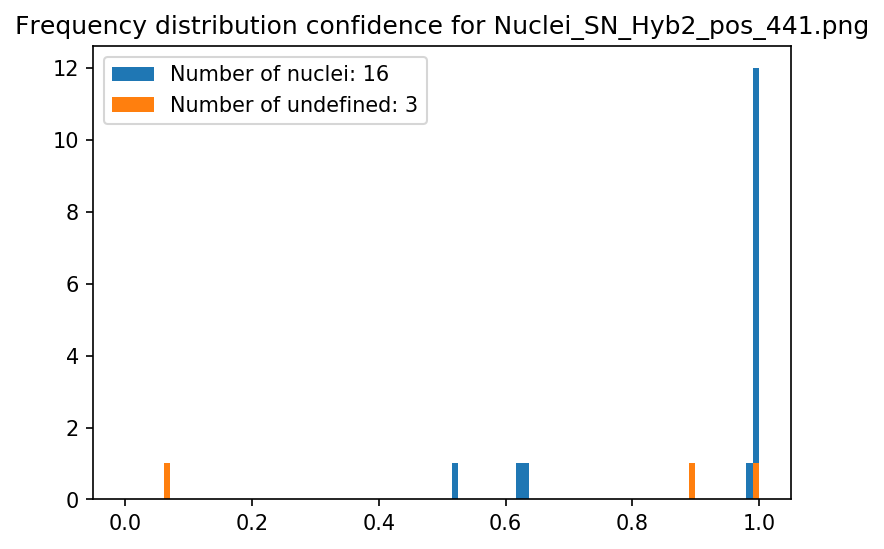

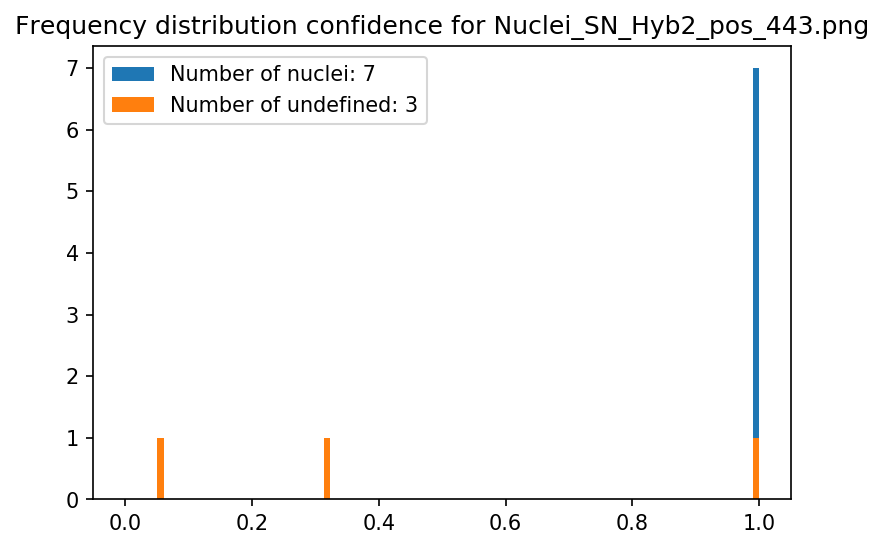

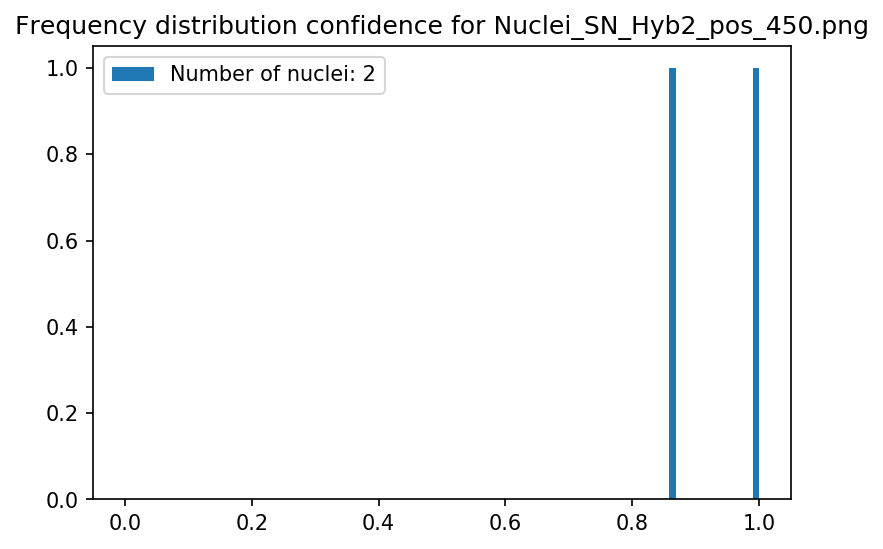

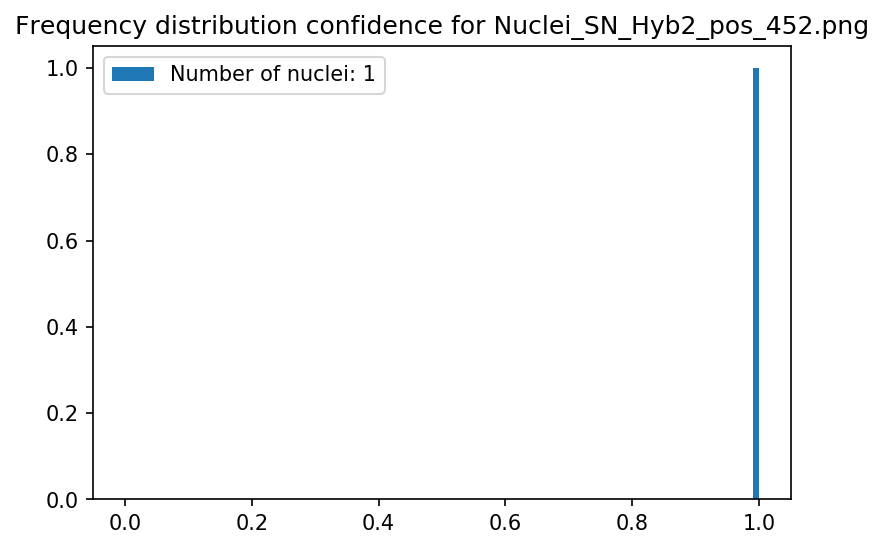

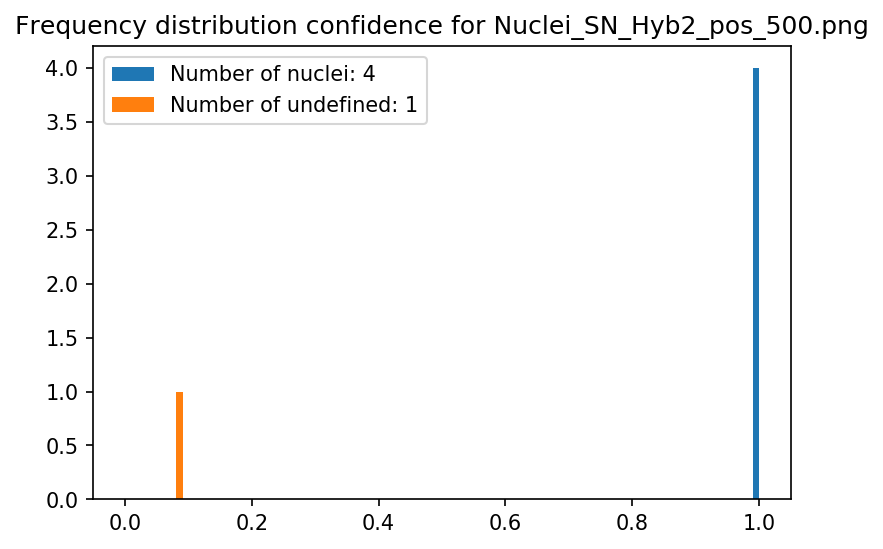

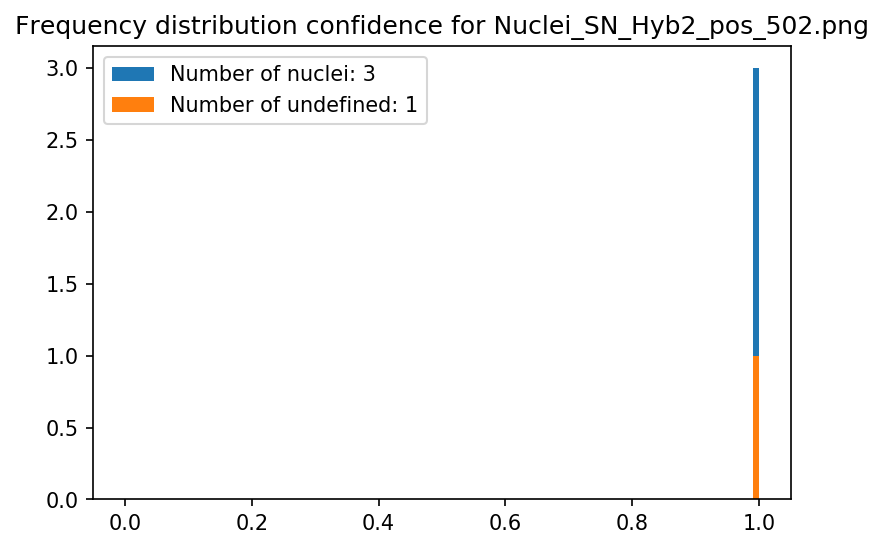

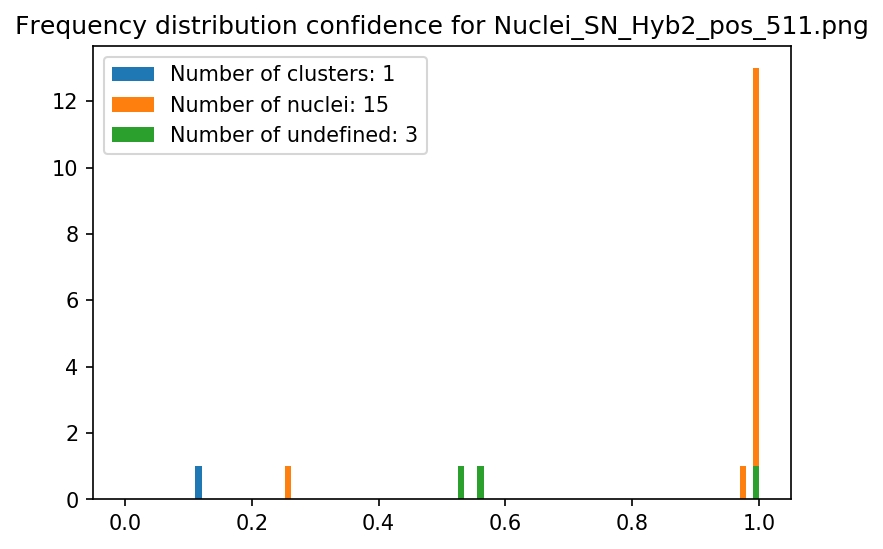

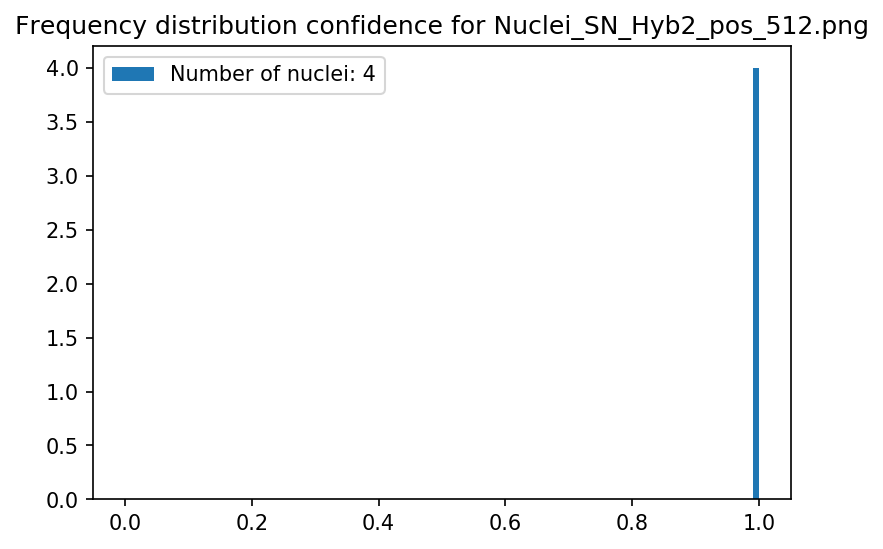

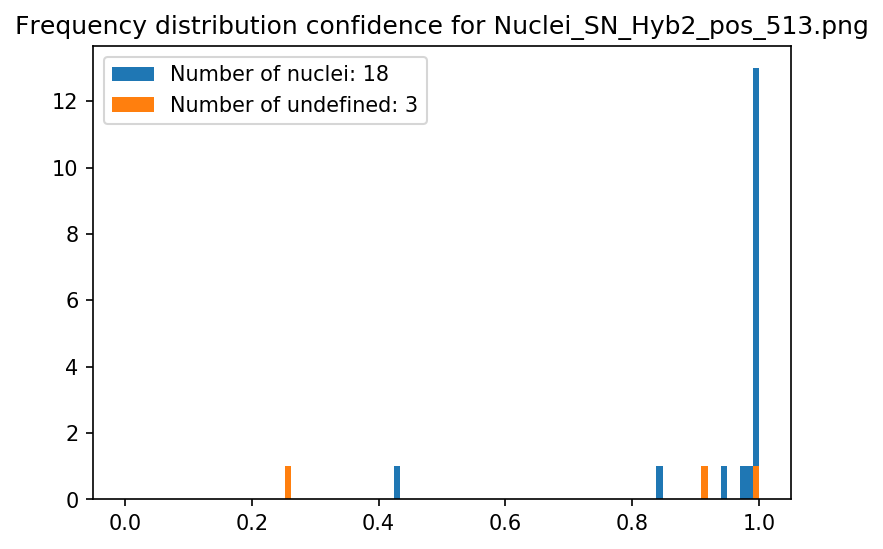

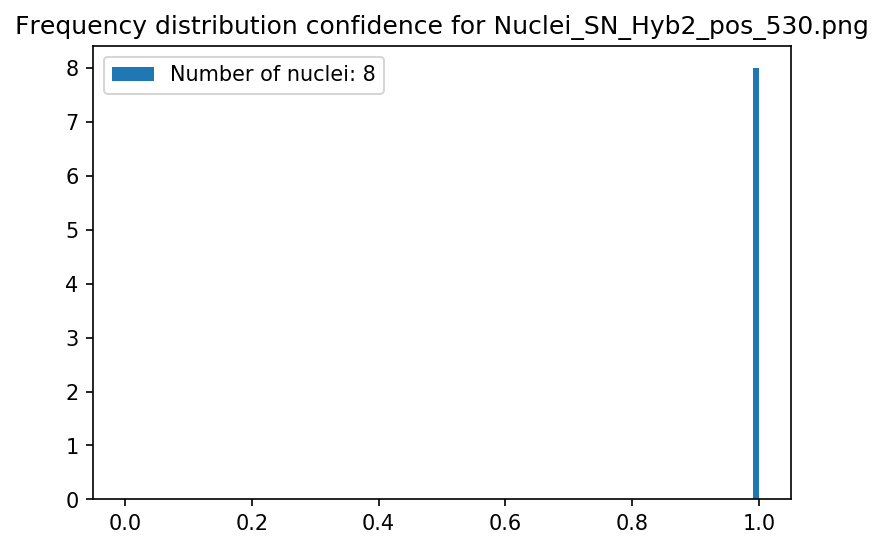

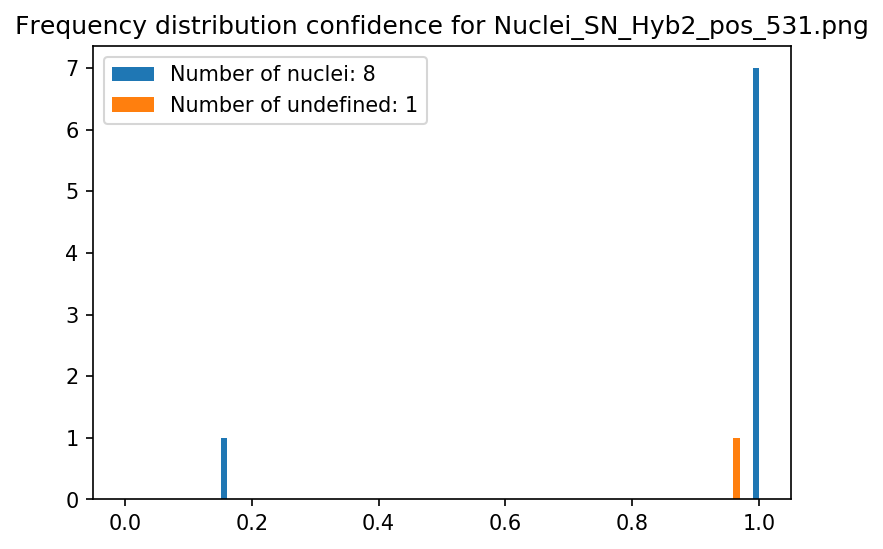

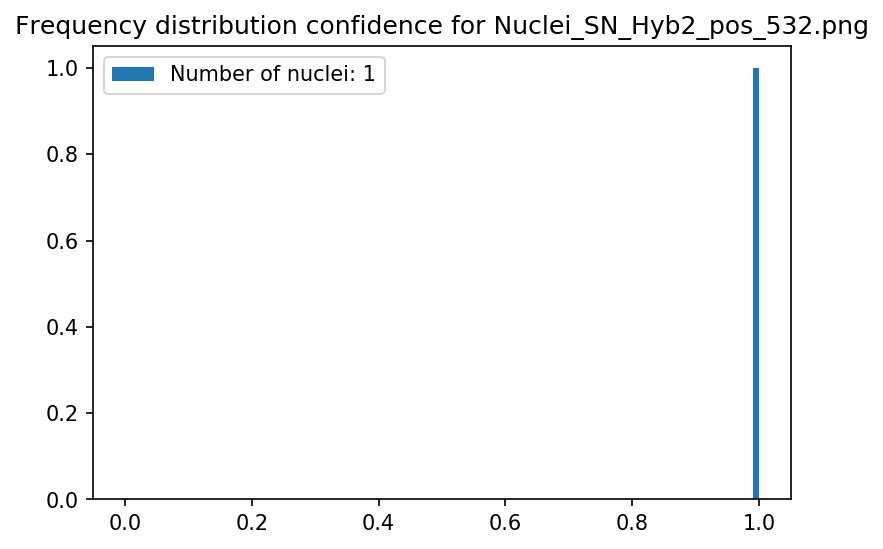

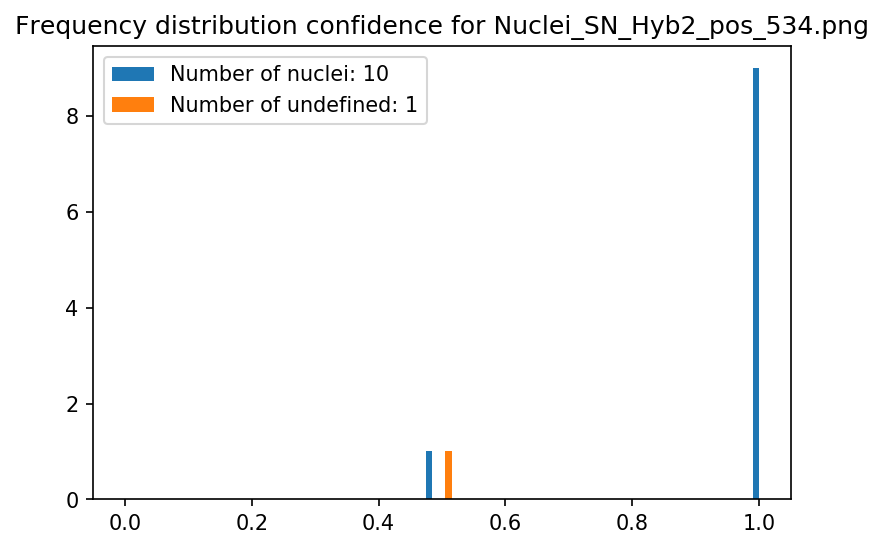

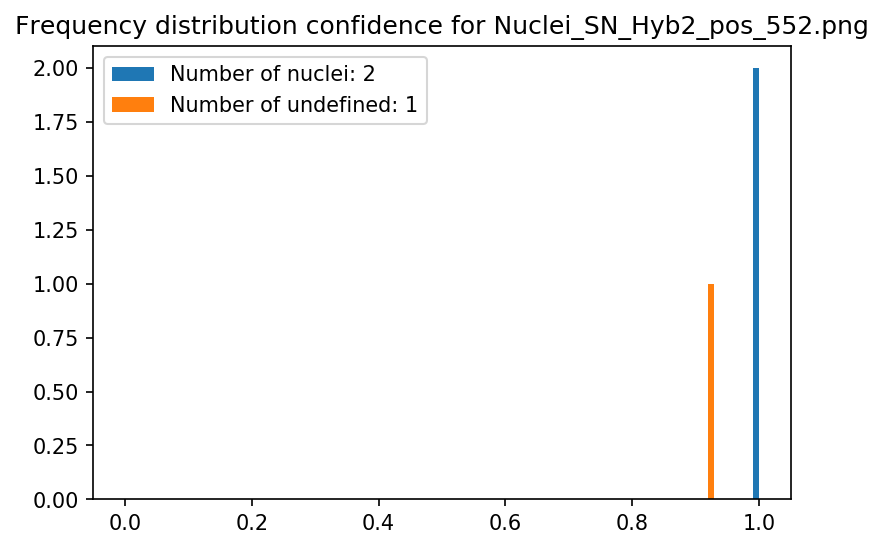

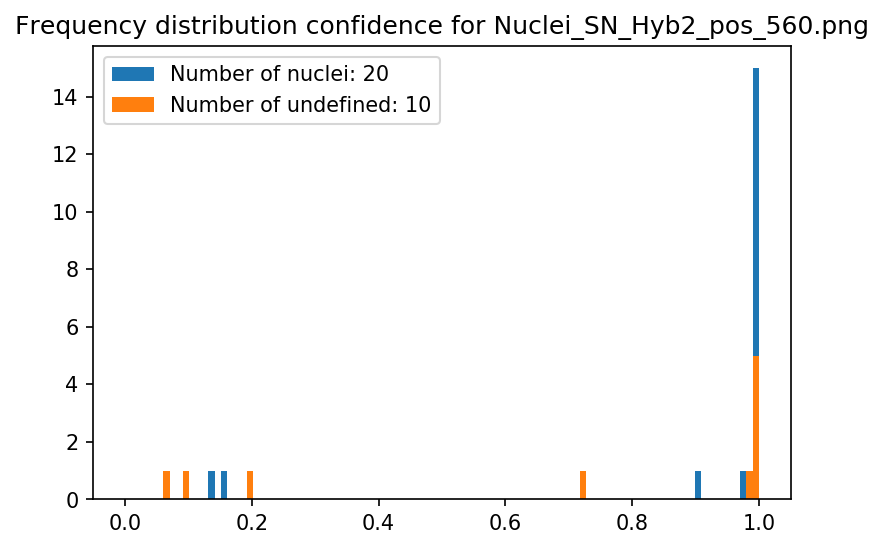

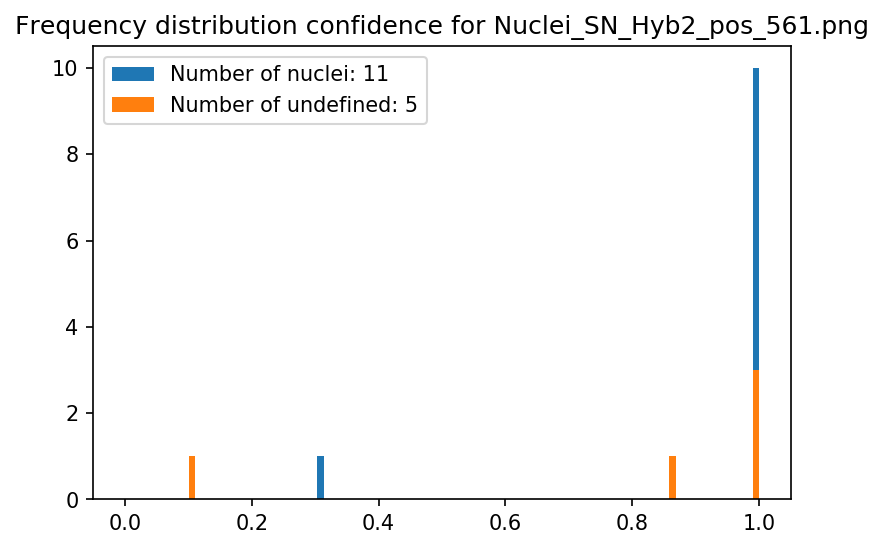

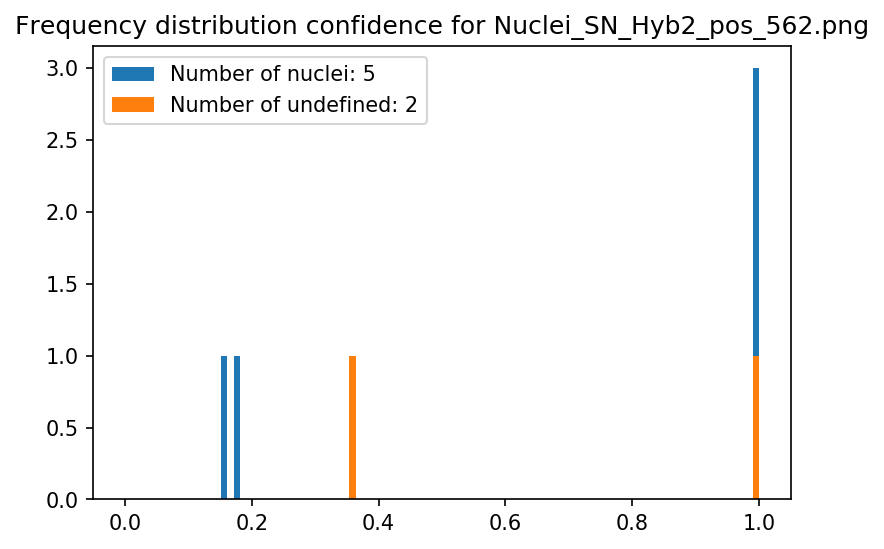

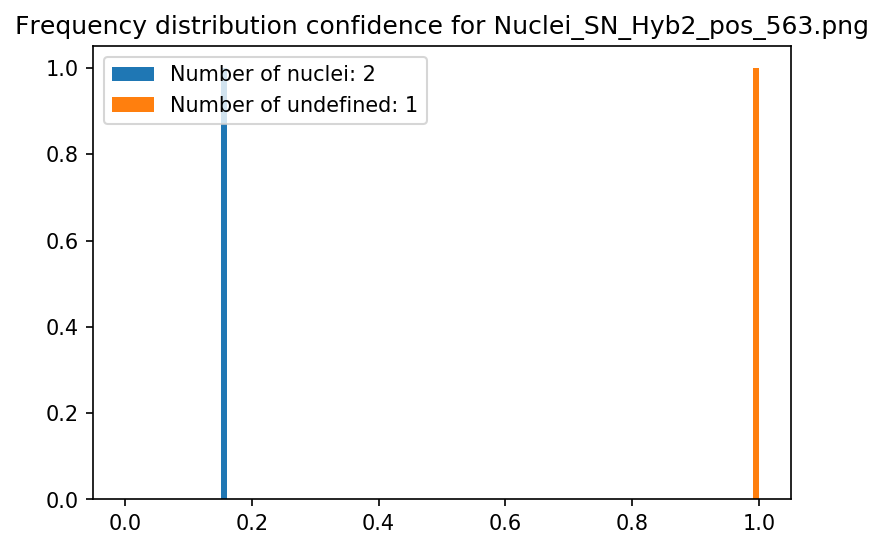

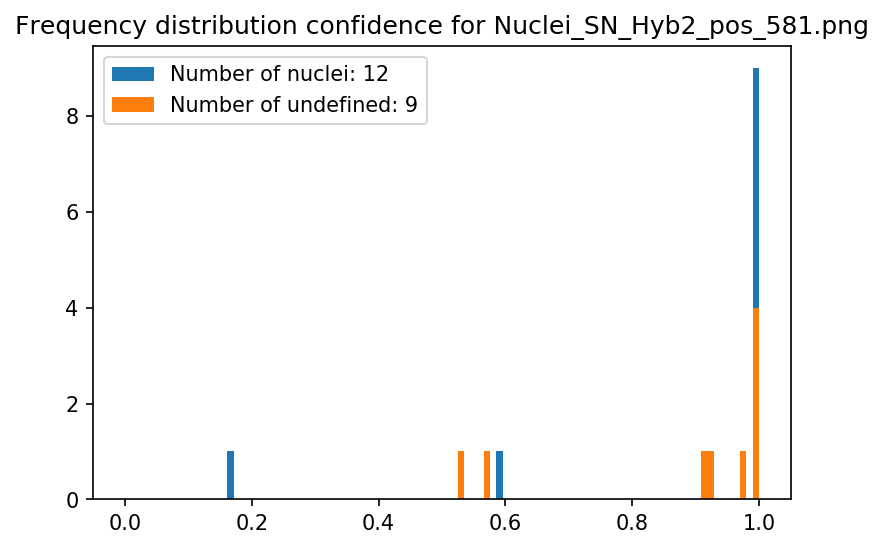

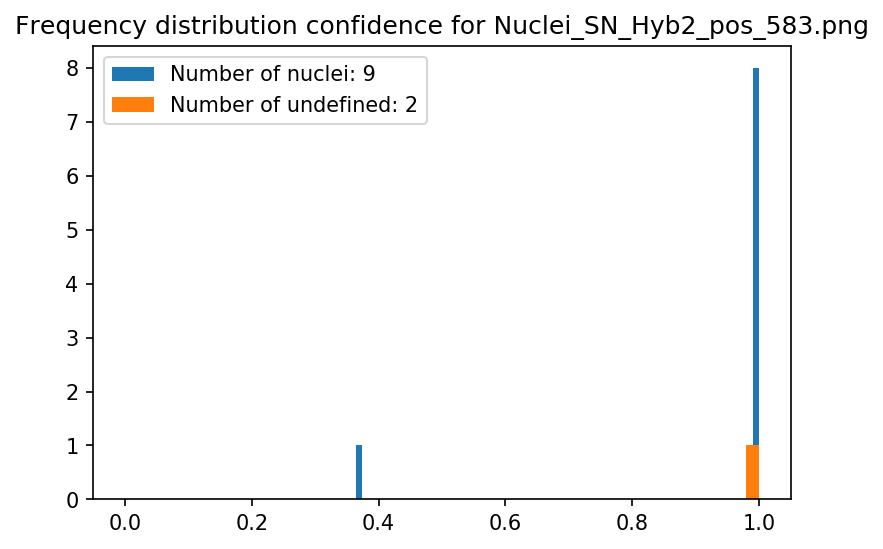

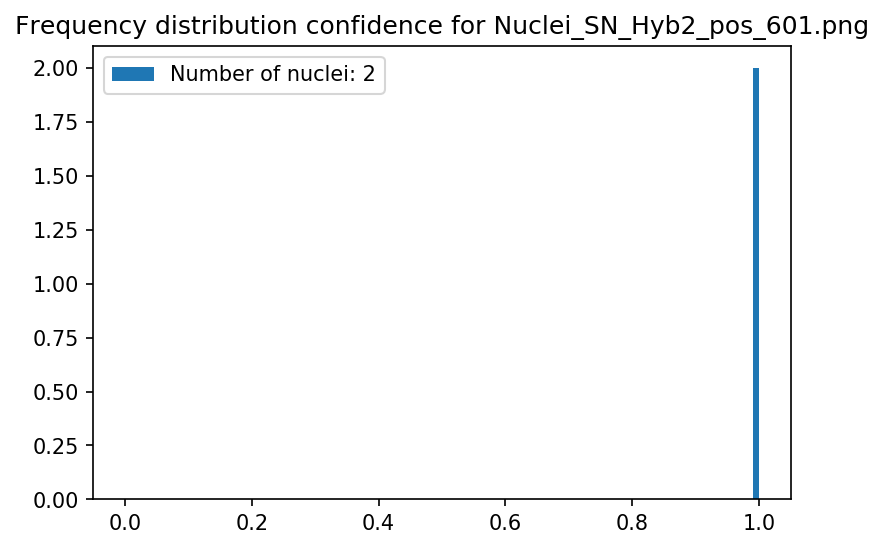

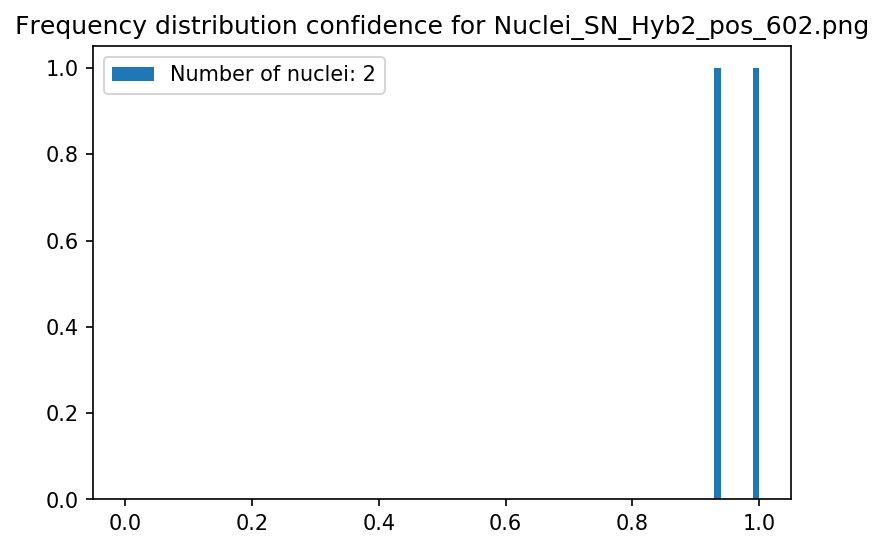

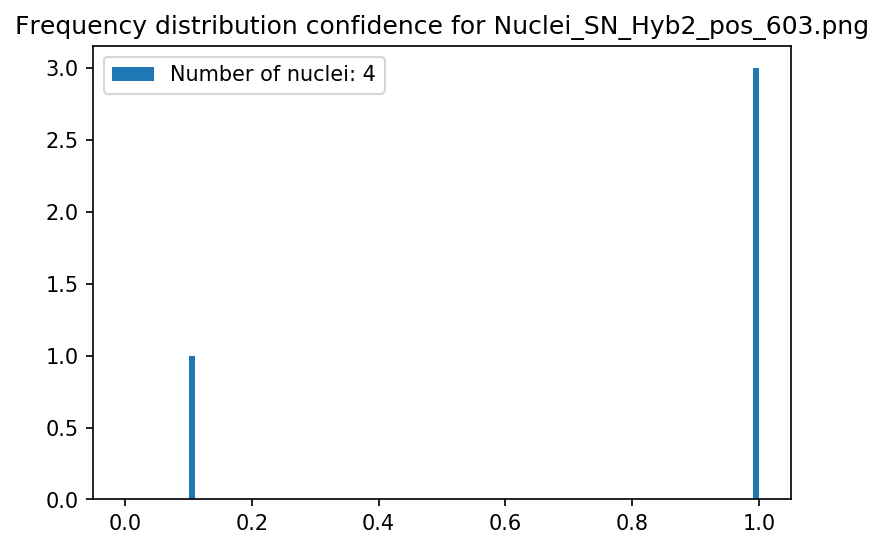

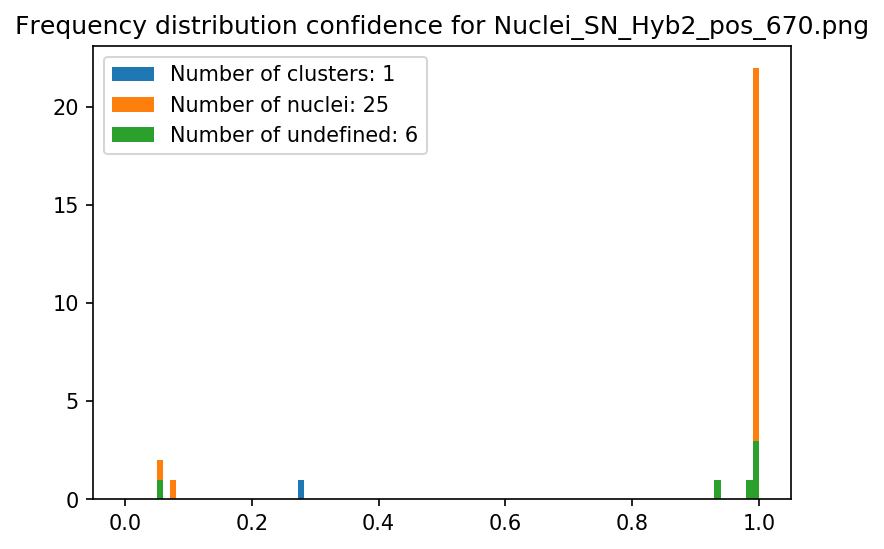

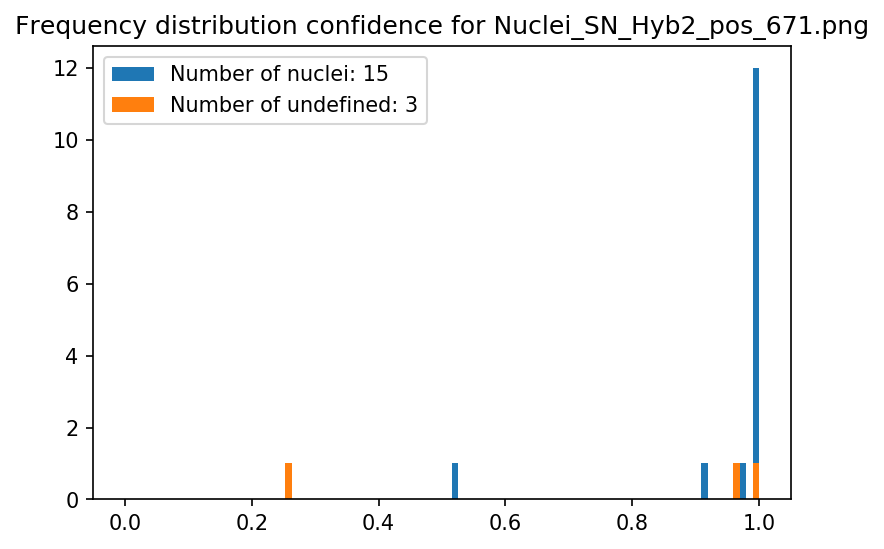

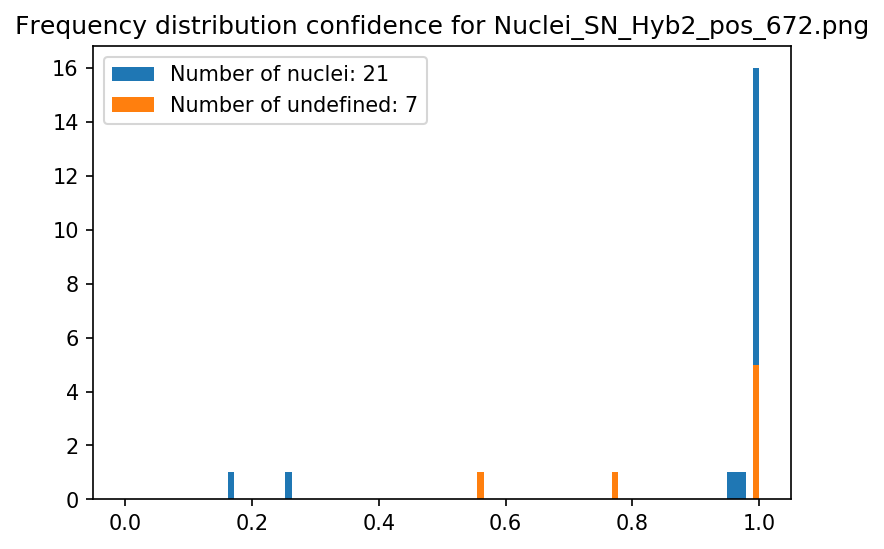

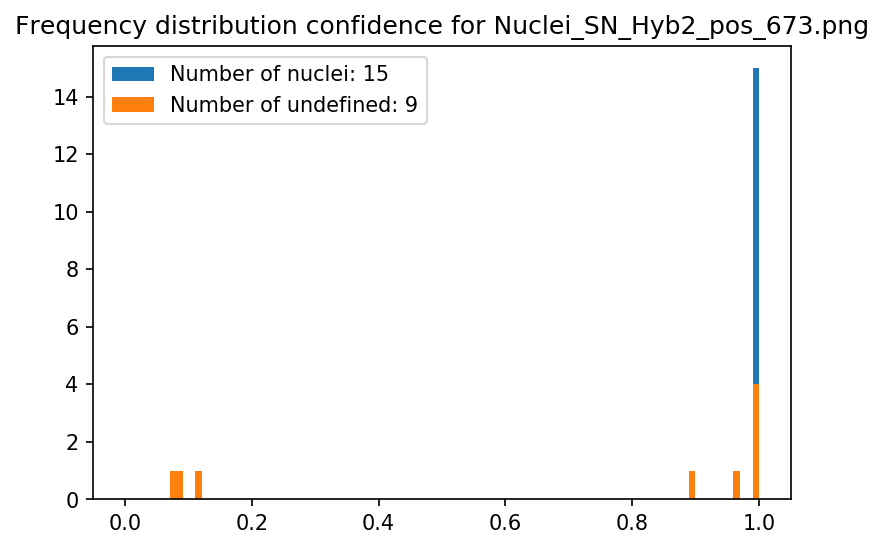

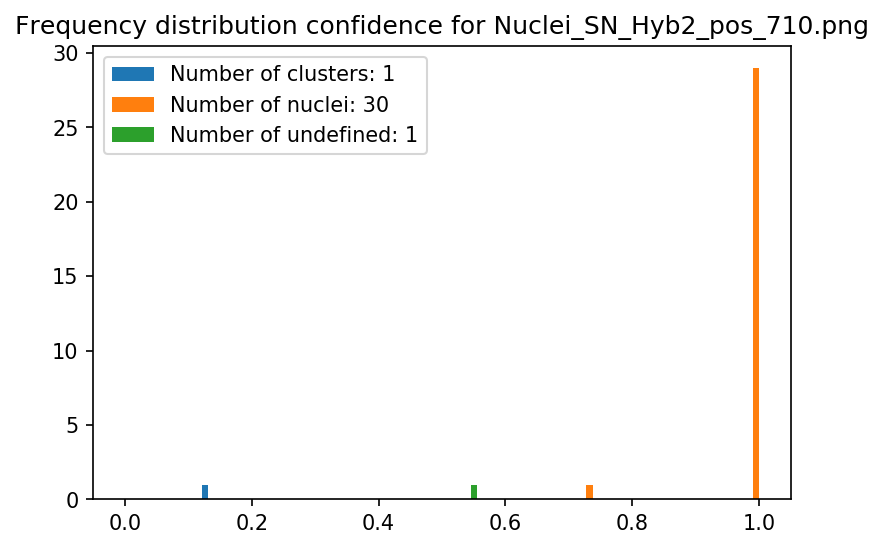

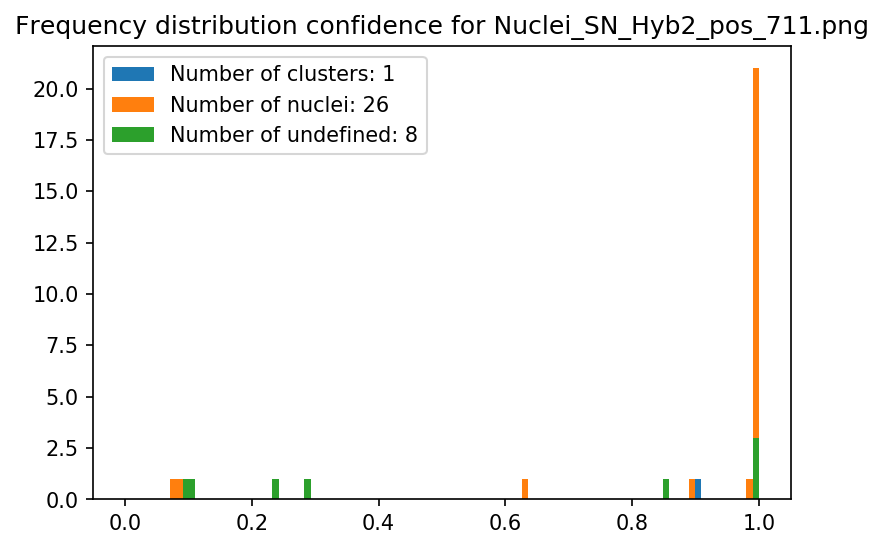

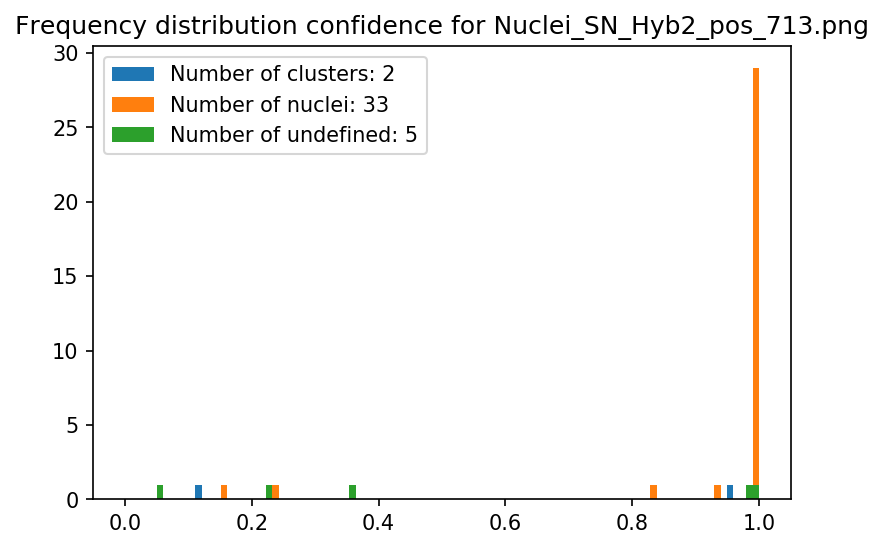

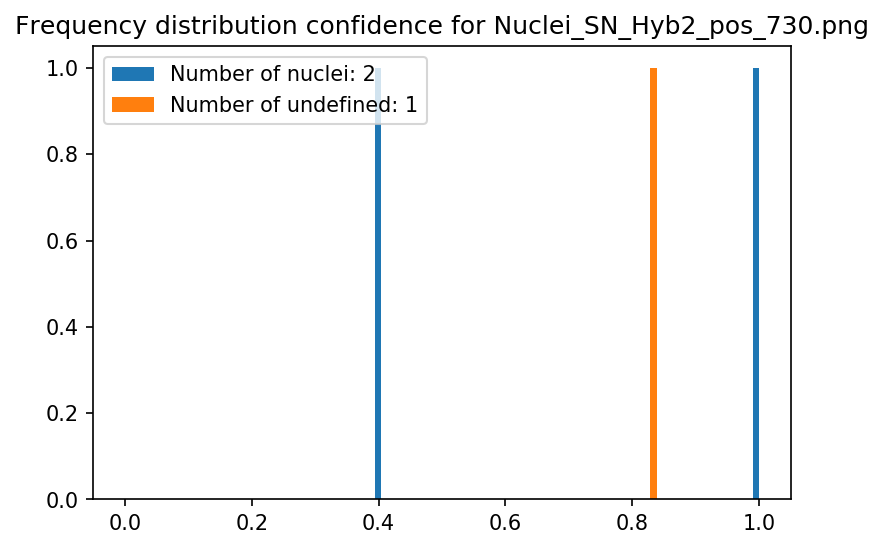

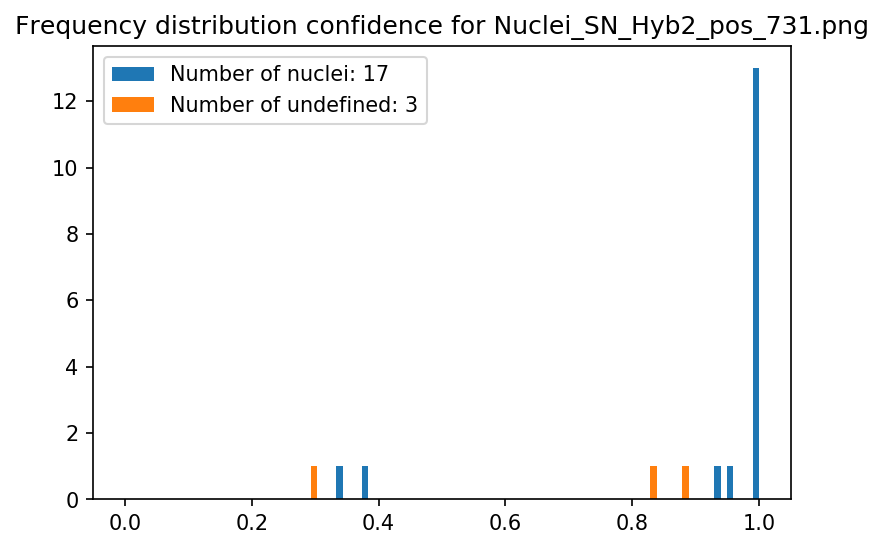

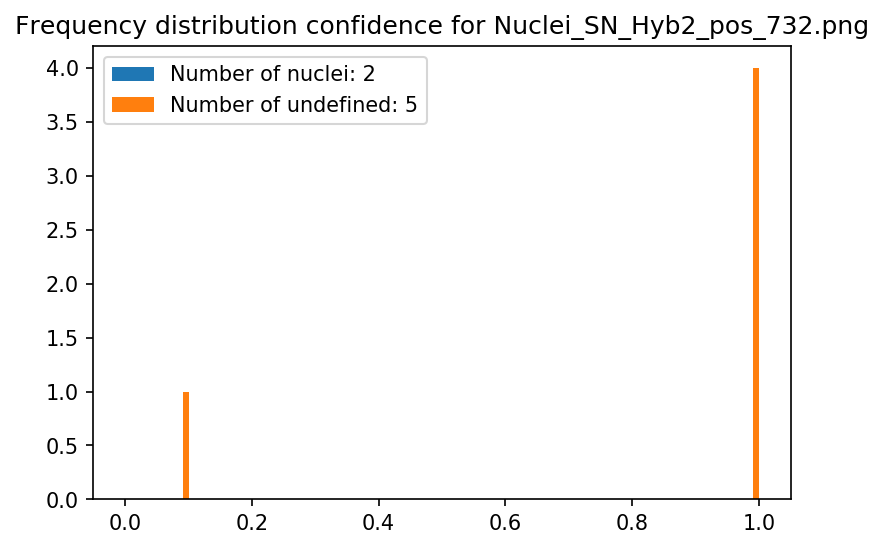

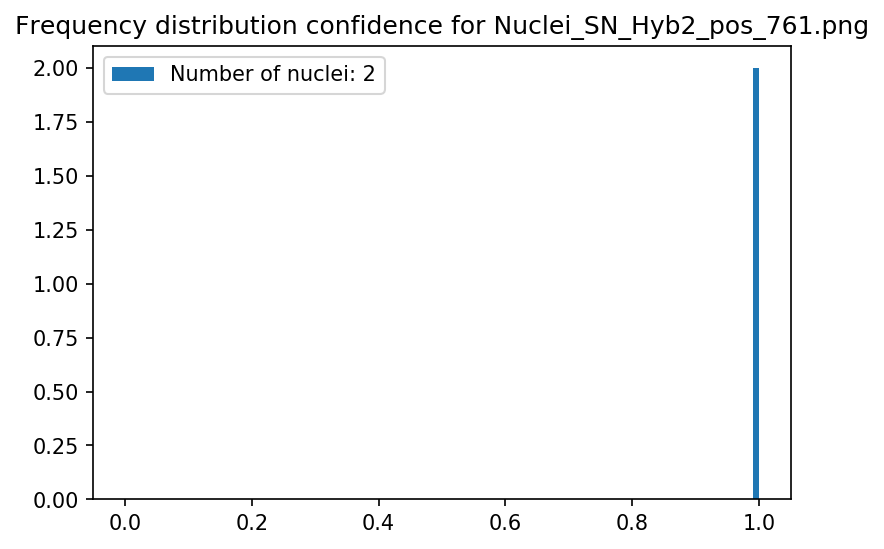

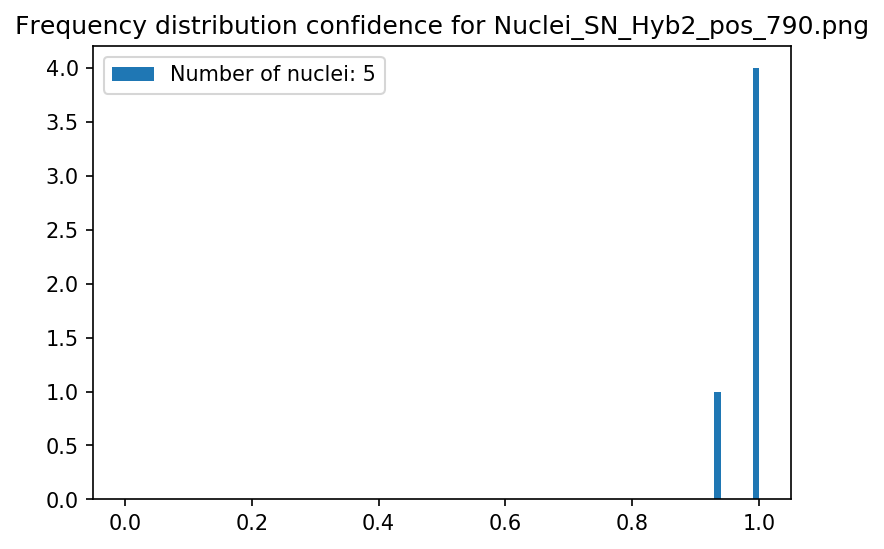

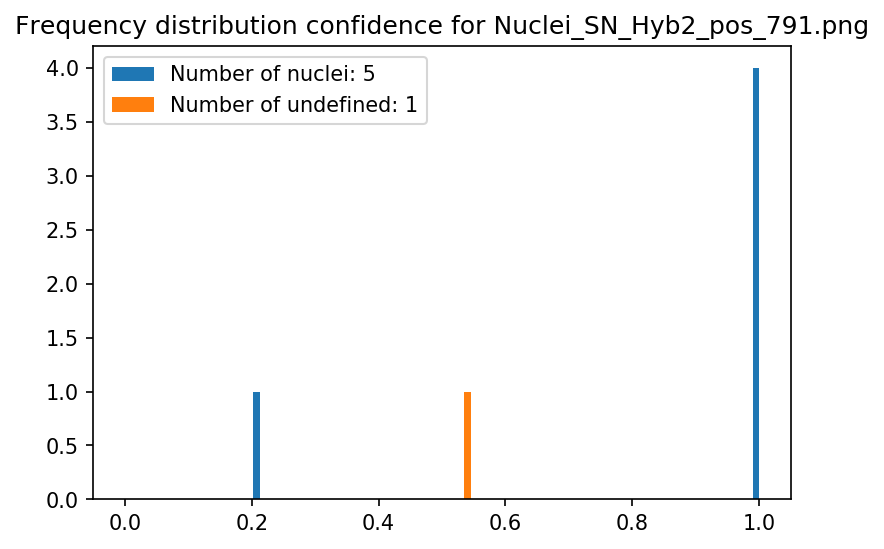

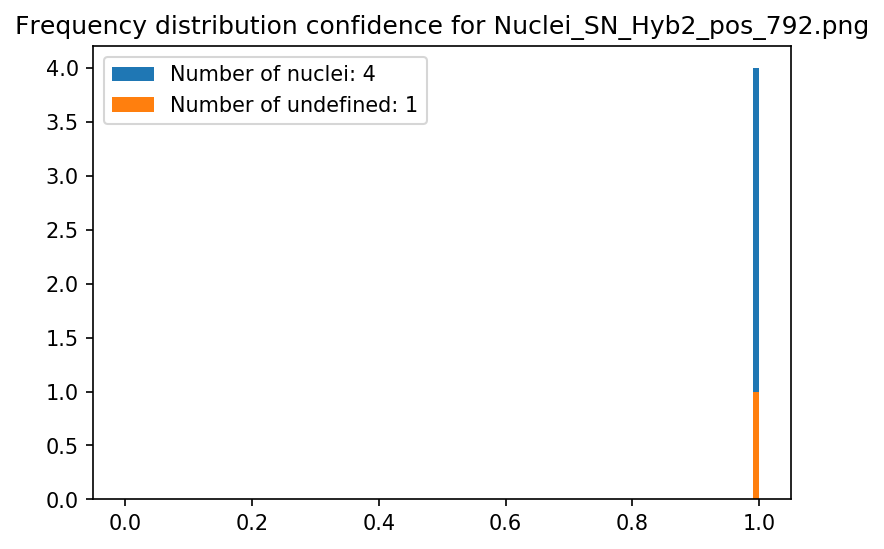

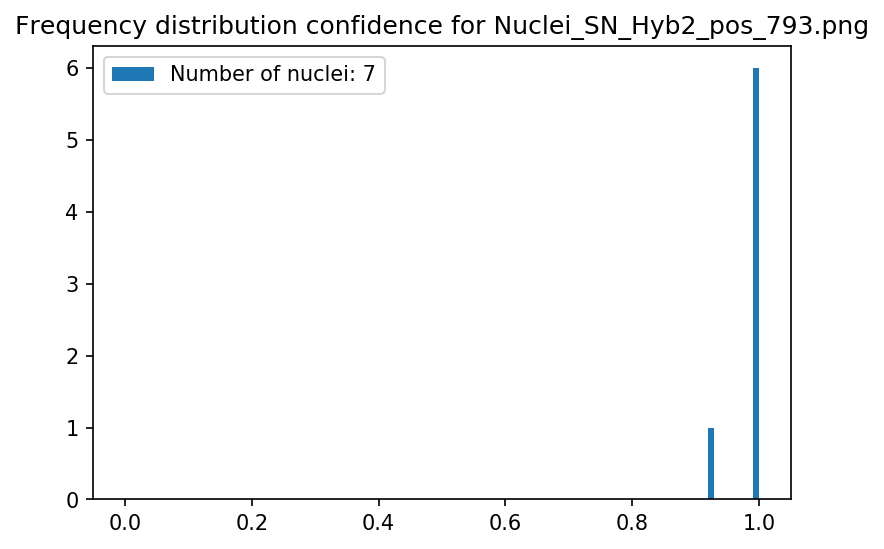

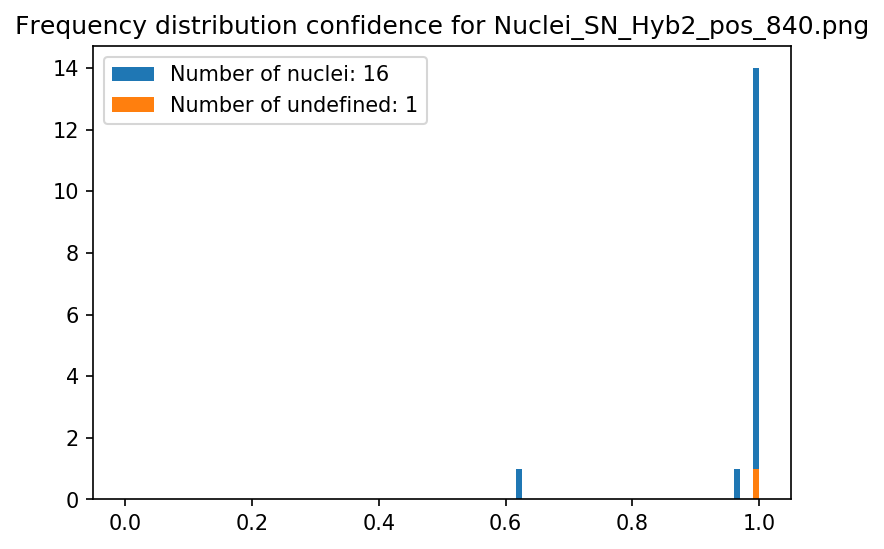

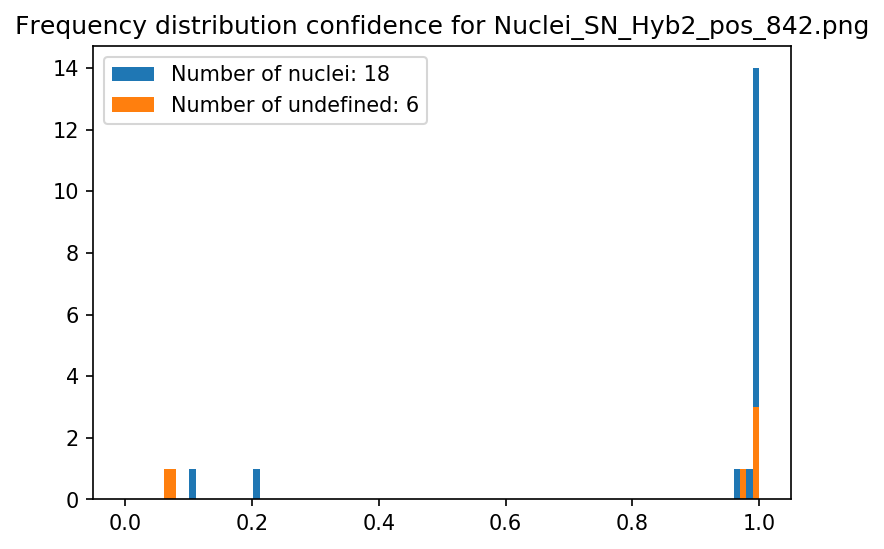

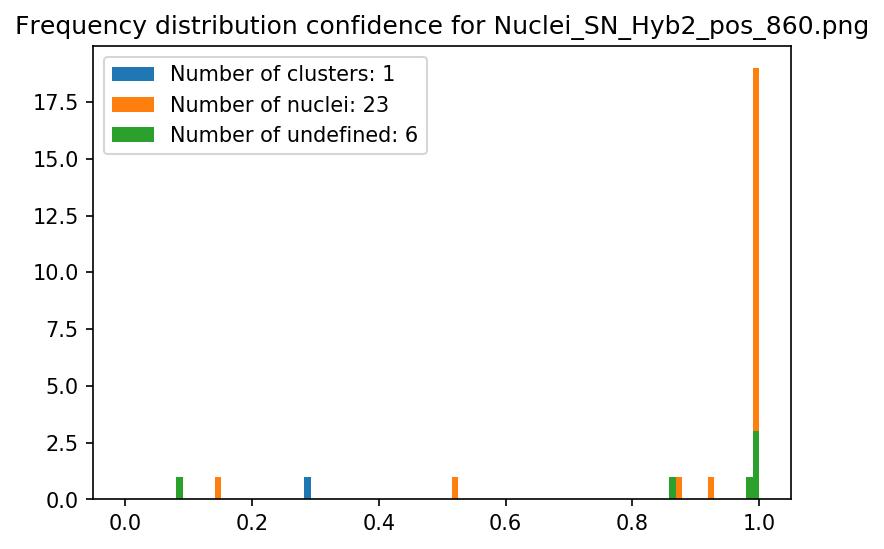

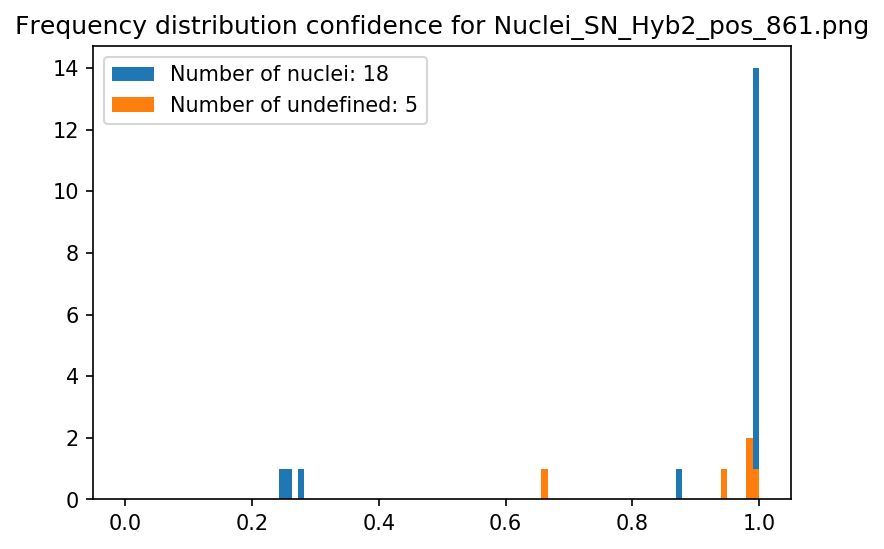

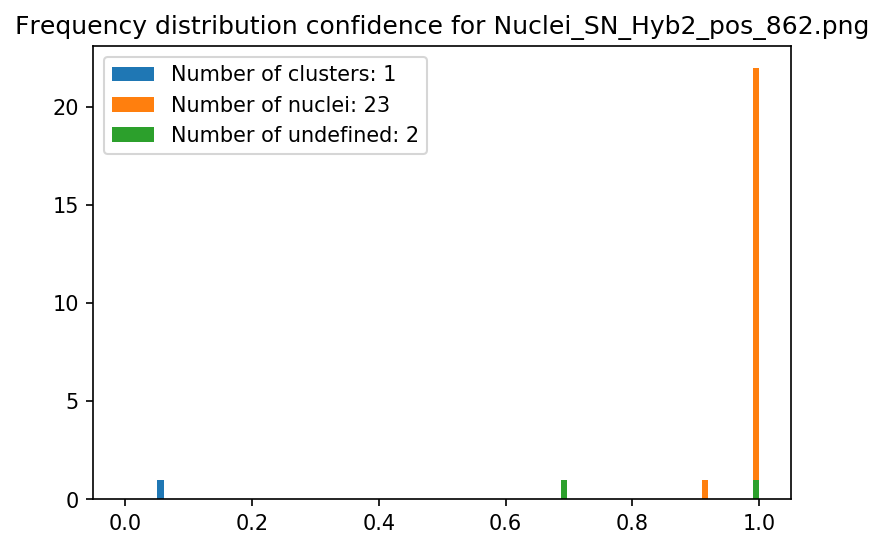

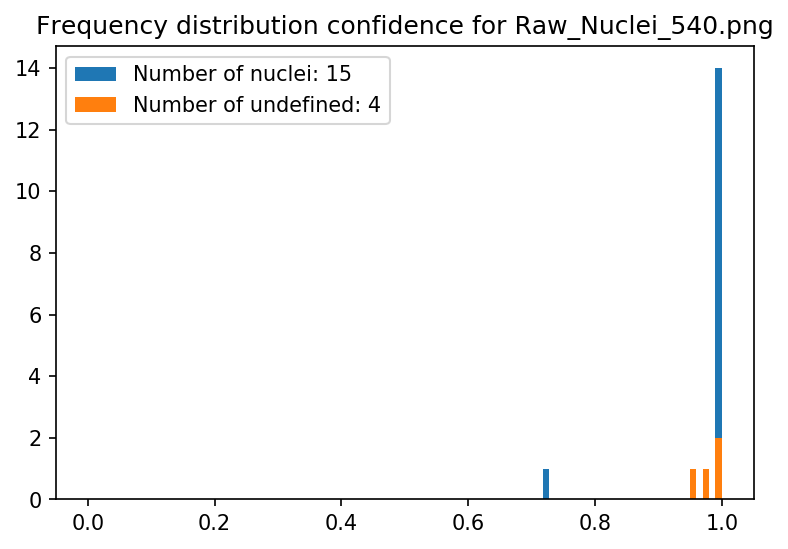

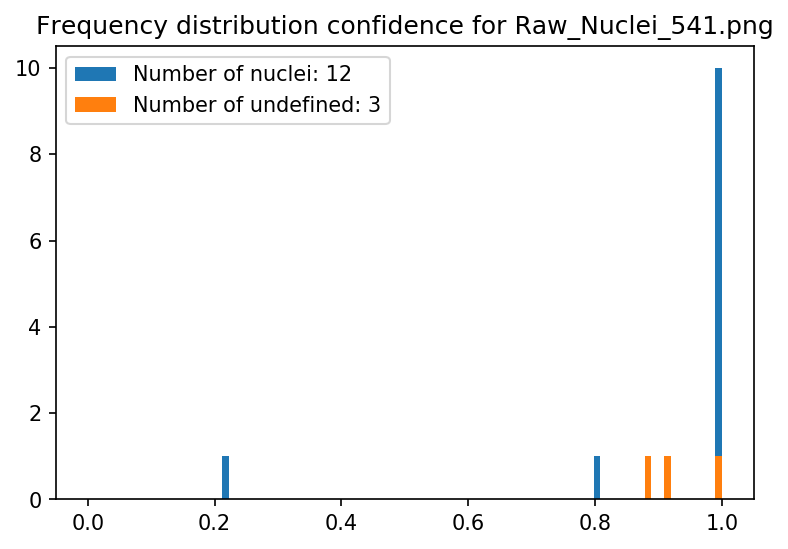

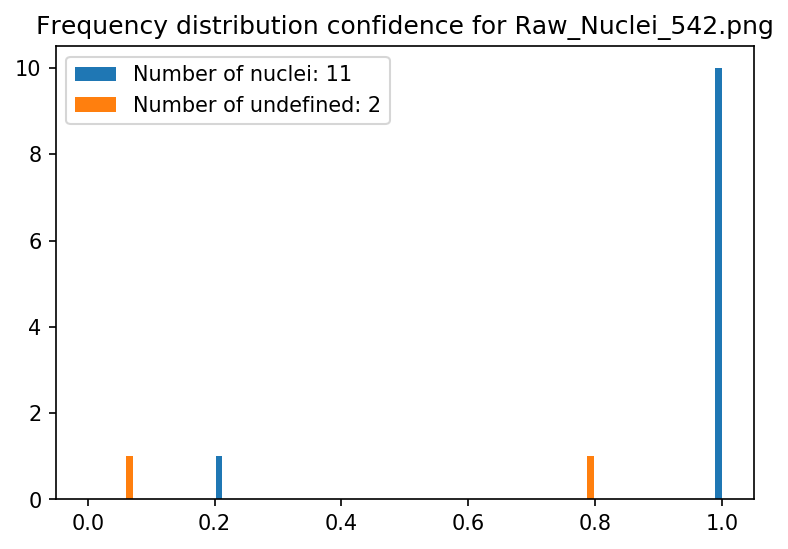

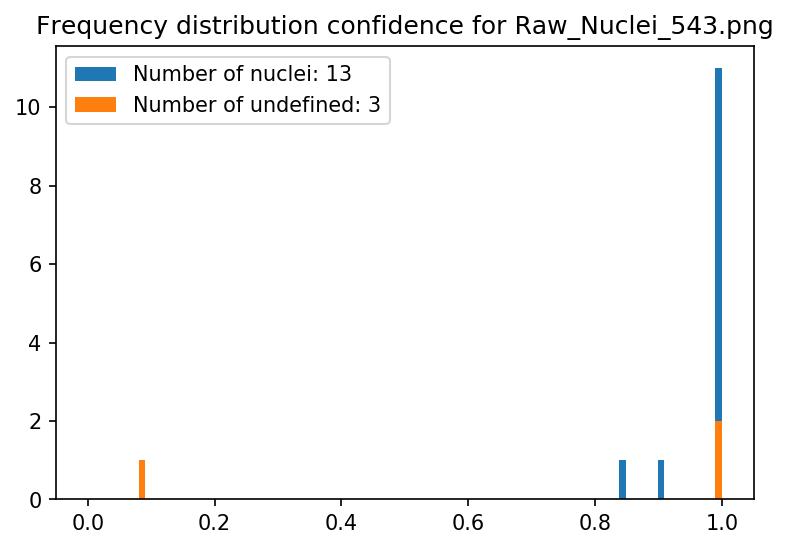

In [11]:
# plot confidence scores
result_path = '/data/proj/smFISH/Students/Max_Senftleben/files/results/20190318_poly_t/'
#result_path = '/home/maxsen/DEEPL/inference_polyt/'

for file_name in predictions:
    
    scores = predictions[file_name].get_field("scores").tolist()
    labels = predictions[file_name].get_field("labels").tolist()
    labels = [categories_to_pass[i] for i in labels]
    histogram(file_name, scores, labels, save_path = save_independently)

In [16]:
# make pdf

from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import letter,A4
from reportlab.platypus import SimpleDocTemplate,Table,PageBreak, Paragraph, Spacer, Image
from reportlab.lib.units import inch
from reportlab.lib.enums import TA_RIGHT
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib.styles import ParagraphStyle

def pdf(result_path, pdf_save_path, title):
    
    styles = getSampleStyleSheet()
    style_right = ParagraphStyle(name='right', parent=styles['Normal'], alignment=TA_RIGHT)
    doc = SimpleDocTemplate(pdf_save_path, topMargin=10)
    Story = []

    # specify title
    Story.append(Paragraph(title, styles['Title']))
    
    a=4
    b=4
    c=3
    print(c)

    
    
    image_names = set([i[:-9] for i in os.listdir(result_path)])
    for image in image_names:
        tb_data_line1 = [[ 
                Image(result_path + image + '_trut.png',a*inch, a*inch,hAlign="MIDDLE"),
                Image(result_path + image + '_bbox.png',   a*inch, a*inch,hAlign="LEFT")
                ]]
        tb1 = Table(tb_data_line1)
        Story.append(tb1)
        
        tb_data_line2 = [[ 
                Image(result_path + image + '_mask.png',a*inch, b*inch,hAlign="RIGHT"),
                Image(result_path + image + '_hist.png',   b*inch, c*inch,hAlign="LEFT")
                ]]
        tb2 = Table(tb_data_line2)
        Story.append(tb2)
        
        Story.append(PageBreak())
    doc.build(Story)
    
        

In [17]:
pdf(save_independently, '/home/max/github/ms2/nuclei_inference.pdf', 'Nuclei segmentation')

3
